# NCSN and U-Net on MNIST, CIFAR-10 and OxfordPets

This notebook is a simplified version of the scripts contained in the same folder.

The goal is to train a model by using Denoising Score Matching, and then generate new samples.

Note that **this notebook is very simplified** compared to the rest of the code. The goal is not to generate very accurate samples, but to sum up the main principles of the method, and show the main ideas of the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.utils import make_grid

from IPython.display import clear_output
from tqdm.notebook import tqdm

from notebook_models import UNet, NoiseConditionalScoreNetwork

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In the cell below, you can choose which model to use, and which dataset.

You can also choose the batch size and the number of epochs, which will influence how long the training will take, but also the quality of the generated samples.

Finally, you can define `n_samples`, which is the number of samples that will be generated.

In [2]:
# Hyperparameters to choose

batch_size = 128 # number of samples per batch
n_epochs = 20 # number of epochs to train the model
n_samples = 10 # number of samples to visualize

model_type = 'NCSN' # choose between 'UNet' and 'NCSN'
dataset_name = 'MNIST' # choose between 'CIFAR10', 'MNIST', 'OxfordPets'

The cell below implements a function `train` which trains a given model on a given dataset.

In [3]:
def train(model, train_loader, n_epochs, lr, sigmas, device = "cpu"):
  """ Train the model on the given dataset. """
  model.to(device)
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr = lr, betas = (0, 0.9))

  loss_history = []
  for epoch in range(n_epochs):
    for x in tqdm(train_loader, desc = f"Epoch {epoch + 1}/{n_epochs}", total = len(train_loader)):
      x = x[0].to(device)
      batch_size = x.shape[0]

      # Choose a random noise level for each image
      labels = torch.randint(len(sigmas), (batch_size,))
      sigma_batch = sigmas[labels].to(x.device)
      sigma_batch = sigma_batch.reshape(-1, *([1] * (len(x.shape) - 1)))

      # Add noise to the image
      noise = torch.randn_like(x)
      x_noisy = x + sigma_batch * noise

      optimizer.zero_grad()

      # Compute the prediction, and the loss
      pred_scores = model(x_noisy, labels.to(x.device))

      noisy_scores = (- noise / sigma_batch).reshape(batch_size, -1)
      pred_scores = pred_scores.reshape(batch_size, -1)

      losses = torch.sum((pred_scores - noisy_scores)**2, axis = -1) / 2
      loss = torch.mean(losses * sigma_batch.flatten()**2)

      # Update the model
      loss.backward()
      optimizer.step()

      loss_history.append(loss.data.cpu().numpy())

    # Visualize the loss
    clear_output()
    plt.plot(loss_history)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Train loss')
    plt.show()

  return loss_history

The cell below loads the dataset based on the variable `dataset_name`.

In [4]:
# Define the transformation to apply to the images, load the dataset, and create the dataloader
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()])

if dataset_name == 'CIFAR10':
  dataset = torchvision.datasets.CIFAR10('CIFAR10', download = True, transform = transform)
elif dataset_name == 'MNIST':
  dataset = torchvision.datasets.MNIST('MNIST', download = True, transform = transform)
elif dataset_name == 'OxfordPets':
    dataset = torchvision.datasets.OxfordPets('OxfordPets', download = True, transform = transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

The cell below defines the model, the noise levels $(\sigma_i)_i$ (in a geometric progression), and trains the model.

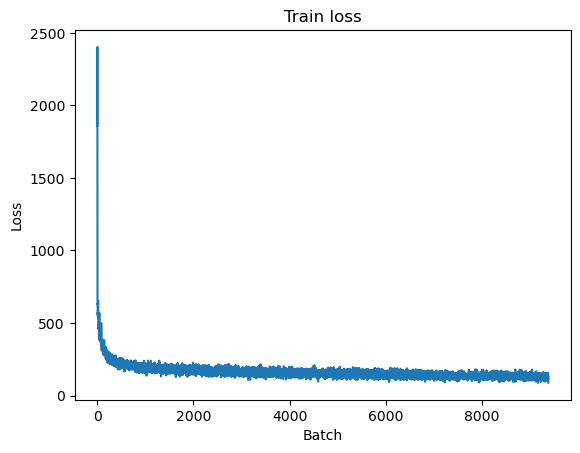

In [ ]:
# Levels of noise to consider
sigmas = torch.tensor(np.exp(np.linspace(np.log(5), np.log(0.01), 10))).float()

# Number of channels in the input image
n_channels = 1 if dataset_name == 'MNIST' else 3

# Create the model
if model_type == 'UNet':
  model = UNet(image_channels = n_channels)
elif model_type == 'NCSN':
  model = NoiseConditionalScoreNetwork(n_channels = n_channels, num_classes = len(sigmas))

# Train the model
loss_history = train(model = model, train_loader = dataloader, n_epochs = n_epochs,
                     lr = 2e-5, sigmas = sigmas, device = device)

The next cell implements a function to generate new samples based on the model that was trained previously, using Langevin dynamics.

In [6]:
def sample(model, n_channels, n_samples, n_steps, sigmas, device = "cpu", eps = 0.00005, save_history = False, save_freq = 100):
    """ Sample from the model using annealed Langevin dynamics. """
    # Initialize the samples
    x = torch.randn(n_samples, n_channels, 32, 32).to(device)

    history = []
    n_steps = n_steps if isinstance(n_steps, list) else [n_steps] * len(sigmas)

    # Annealed Langevin dynamics
    with torch.no_grad():
      for i, sigma in enumerate(sigmas):
        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps[i]):
          # Compute the score
          sigma_batch = torch.ones(n_samples, device = device, dtype = torch.int) * i
          score = model(x, sigma_batch)

          # Update the samples using Langevin dynamics
          x += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x)

          # Save the results
          if save_history and k % save_freq == 0:
            history.append(x.cpu())

    if save_history:
      return x.cpu(), history
    return x.cpu()

In [24]:
model.eval()
n_steps = 1000
samples, history = sample(model, n_channels = n_channels, n_samples = n_samples, n_steps = n_steps, save_freq = n_steps, sigmas = sigmas,
                          save_history = True, device = device)

And we can display the generated samples:

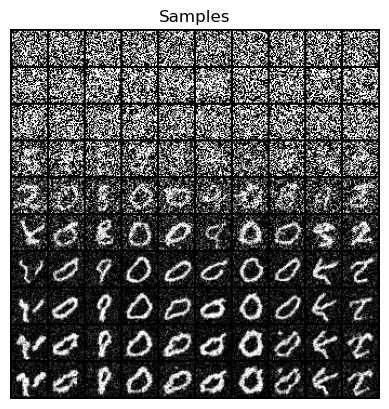

In [ ]:
nrow = 10

history_print = torch.stack(history).view(-1, n_channels, 32, 32)

grid_img = make_grid(history_print, nrow = nrow).permute(1, 2, 0).clip(0, 1)
plt.imshow(grid_img, cmap = 'Greys' if n_channels == 1 else None)
plt.axis("off")
plt.title('Samples')
plt.show()

These samples do not necessarily look good. For (much) better results, you should use the rest of the code as described in the README file.